# Lane Detection

In [3]:
# %pip install --upgrade pip --quiet

In [4]:
# %pip install numpy open3d opencv-python seaborn rospkg cachetools numpy-quaternion rosbag pycryptodome --quiet

In [5]:
# %pip install scikit-learn

In [6]:
import numpy as np
import open3d as o3d
import quaternion
import cv2 as cv
import rosbag

import matplotlib.pyplot as plt

from dataclasses import dataclass
from datetime import datetime, timedelta

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
import sys

sys.path.append("../src/")

In [8]:
%load_ext autoreload

In [9]:
#from kal2_perception.lane_detector_node import LaneDetectorNode

In [10]:
%autoreload 2

In [11]:
#%aimport kal2_perception.lane_detector_node

In [12]:
@dataclass
class ImageStamped:
    image: np.ndarray
    timestamp: datetime

In [13]:
def datetime_from_ros_timestamp(secs, nsecs):
    return datetime.fromtimestamp(secs) + timedelta(microseconds=nsecs / 1000)

In [14]:
def extract_images_with_timestamp(bag: str, topic: str, n=10):
    from cv_bridge import CvBridge

    bridge = CvBridge()

    images = []

    with rosbag.Bag(bag) as bag:
        for index, (topic, msg, _) in enumerate(bag.read_messages(topics=[topic])):
            encoding = "bgr8" if msg.encoding == "rgb8" else "16UC1"
            timestamp = datetime_from_ros_timestamp(msg.header.stamp.secs, msg.header.stamp.nsecs)

            cv_image = bridge.imgmsg_to_cv2(msg, encoding)
            images.append(ImageStamped(image=cv_image, timestamp=timestamp))

            if index == n - 1:
                break
    return np.array(images)

In [15]:
BAG_FILE = "/home/josua/2024-04-26-14-10-52.bag"
color_images = extract_images_with_timestamp(BAG_FILE, topic="/camera_front/color/image_raw")
depth_images = extract_images_with_timestamp(BAG_FILE, topic="/camera_front/aligned_depth_to_color/image_raw")

In [16]:
def create_rgbd_images(color_images, depth_images):
    rgbd_images = []

    for color_image in color_images:
        timestamp = color_image.timestamp

        try:
            depth_image = next(depth_image for depth_image in depth_images if depth_image.timestamp == timestamp)
        except StopIteration:
            continue

        color_image = o3d.geometry.Image(color_image.image)
        depth_image = o3d.geometry.Image(depth_image.image)
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_image, depth_image, depth_scale=1000.0, depth_trunc=20, convert_rgb_to_intensity=False
        )
        rgbd_images.append(rgbd_image)
    return rgbd_images

In [17]:
rgbd_images = create_rgbd_images(color_images, depth_images)

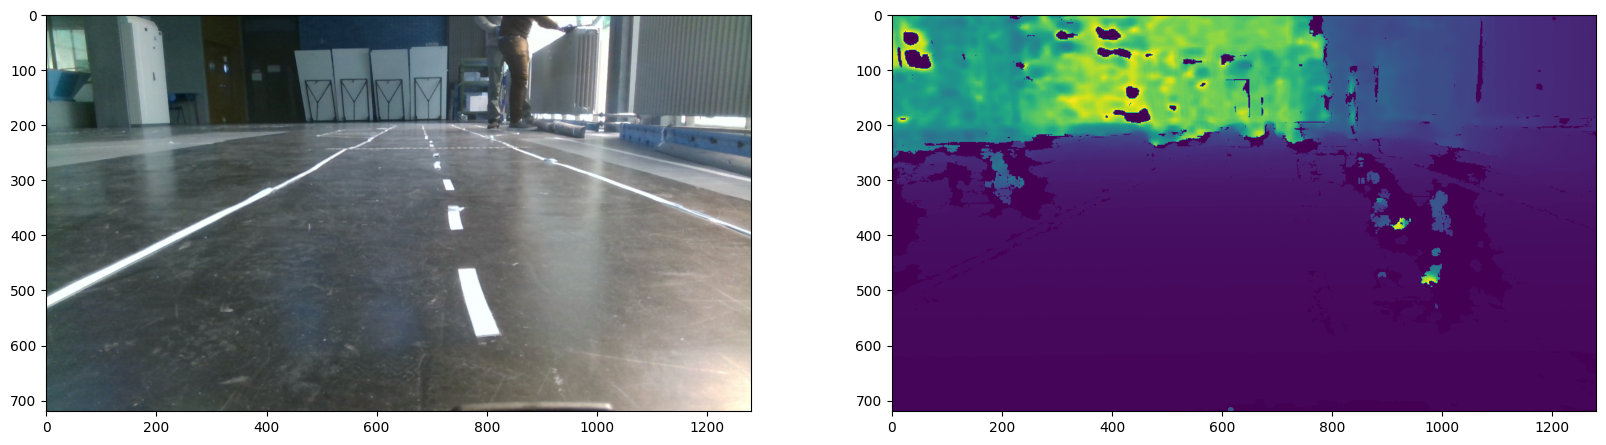

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(rgbd_images[0].depth)

In [20]:
# Full kernels
FULL_KERNEL_3 = np.ones((3, 3), np.uint8)
FULL_KERNEL_5 = np.ones((5, 5), np.uint8)
FULL_KERNEL_7 = np.ones((7, 7), np.uint8)
FULL_KERNEL_9 = np.ones((9, 9), np.uint8)
FULL_KERNEL_31 = np.ones((31, 31), np.uint8)

# 3x3 cross kernel
CROSS_KERNEL_3 = np.asarray(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ],
    dtype=np.uint8,
)

# 5x5 cross kernel
CROSS_KERNEL_5 = np.asarray(
    [
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
    ],
    dtype=np.uint8,
)

# 5x5 diamond kernel
DIAMOND_KERNEL_5 = np.array(
    [
        [0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0],
    ],
    dtype=np.uint8,
)

# 7x7 cross kernel
CROSS_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ],
    dtype=np.uint8,
)

# 7x7 diamond kernel
DIAMOND_KERNEL_7 = np.asarray(
    [
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
    ],
    dtype=np.uint8,
)


def fill_in_fast(depth_map, max_depth=100.0, custom_kernel=DIAMOND_KERNEL_5, extrapolate=False, blur_type="bilateral"):
    """Fast, in-place depth completion.

    Args:
        depth_map: projected depths
        max_depth: max depth value for inversion
        custom_kernel: kernel to apply initial dilation
        extrapolate: whether to extrapolate by extending depths to top of
            the frame, and applying a 31x31 full kernel dilation
        blur_type:
            'bilateral' - preserves local structure (recommended)
            'gaussian' - provides lower RMSE

    Returns:
        depth_map: dense depth map
    """

    # Invert
    valid_pixels = depth_map > 0.1
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

    # Dilate
    depth_map = cv.dilate(depth_map, custom_kernel)

    # Hole closing
    depth_map = cv.morphologyEx(depth_map, cv.MORPH_CLOSE, FULL_KERNEL_5)

    # Fill empty spaces with dilated values
    empty_pixels = depth_map < 0.1
    dilated = cv.dilate(depth_map, FULL_KERNEL_7)
    depth_map[empty_pixels] = dilated[empty_pixels]

    # Extend highest pixel to top of image
    if extrapolate:
        top_row_pixels = np.argmax(depth_map > 0.1, axis=0)
        top_pixel_values = depth_map[top_row_pixels, range(depth_map.shape[1])]

        for pixel_col_idx in range(depth_map.shape[1]):
            depth_map[0 : top_row_pixels[pixel_col_idx], pixel_col_idx] = top_pixel_values[pixel_col_idx]

        # Large Fill
        empty_pixels = depth_map < 0.1
        dilated = cv.dilate(depth_map, FULL_KERNEL_31)
        depth_map[empty_pixels] = dilated[empty_pixels]

    # Median blur
    depth_map = cv.medianBlur(depth_map, 5)

    # Bilateral or Gaussian blur
    if blur_type == "bilateral":
        # Bilateral blur
        depth_map = cv.bilateralFilter(depth_map, 5, 1.5, 2.0)
    elif blur_type == "gaussian":
        # Gaussian blur
        valid_pixels = depth_map > 0.1
        blurred = cv.GaussianBlur(depth_map, (5, 5), 0)
        depth_map[valid_pixels] = blurred[valid_pixels]

    # Invert
    valid_pixels = depth_map > 0.1
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

    return depth_map

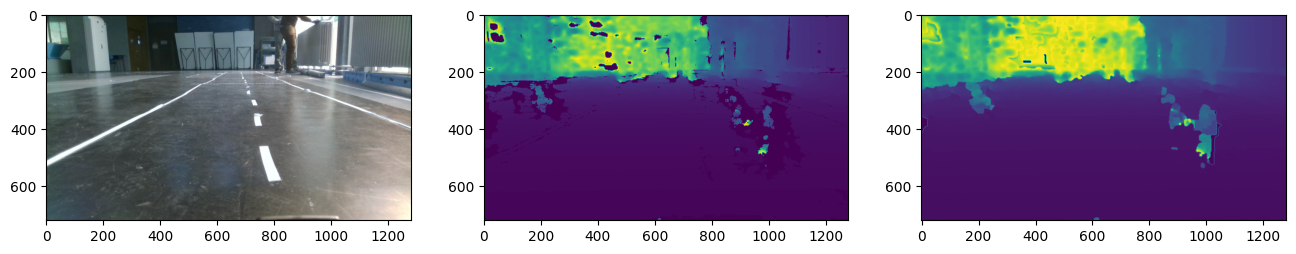

In [21]:
depth = np.asarray(rgbd_images[0].depth).copy()
filled = fill_in_fast(depth, max_depth=16, custom_kernel=DIAMOND_KERNEL_5, extrapolate=True, blur_type="gaussian")

fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(rgbd_images[0].depth)
ax[2].imshow(filled)

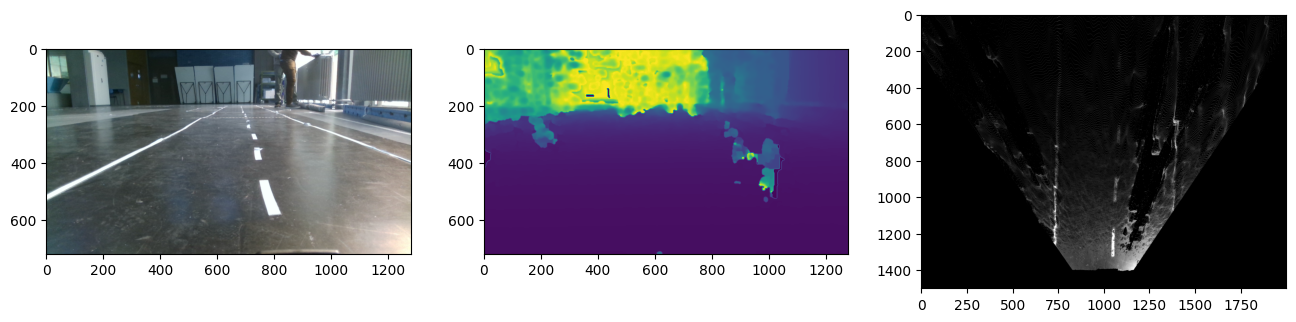

In [22]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
extrinsic_matrix = np.array(
    [
        [-1.0, 0.005, -0.004, -0.0],
        [0.005, 0.168, -0.986, -0.236],
        [-0.005, -0.986, -0.168, -0.062],
        [0.0, 0.0, 0.0, 1.0],
    ]
)

filled_rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgbd_images[0].color, o3d.geometry.Image(filled * 1000.0)
)
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(filled_rgbd, intrinsics, project_valid_depth_only=False)
point_cloud.transform(extrinsic_matrix)

pcd = o3d.t.geometry.PointCloud.from_legacy(point_cloud)
scale = 4.0
intrinsic = o3d.core.Tensor(np.array([[scale * 1000, 0, 1000], [0, scale * 1000, 1800], [0, 0, 1]]))
extrinsics = o3d.core.Tensor(np.array([[-1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 5], [0, 0, 0, 1]]))
rgbd_reproj = pcd.project_to_rgbd_image(2000, 1500, intrinsic, extrinsics, depth_scale=1000, depth_max=20.0)

fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(rgbd_images[0].color, cmap="gray")
ax[1].imshow(filled)
ax[2].imshow(rgbd_reproj.color, cmap="gray")

In [23]:
def create_plane_mesh(normal, dist, size=1):
    # rot = o3d.geometry.get_rotation_matrix_from_xyz((0, -np.pi / 2, 0))
    plane = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=0.01)
    # plane.rotate(rot, center=(0, 0, 0))
    # plane.translate(center - normal * size / 2)
    desired_normal = np.array([0, 0, 1])
    rotation_axis = np.cross(normal, desired_normal)
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)  # Normalize the axis

    # Compute the angle between the original normal and the desired normal
    cos_theta = np.dot(normal, desired_normal)
    angle = -np.arccos(cos_theta) + np.pi

    # Compute the rotation matrix using the rotation axis and angle
    R = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * angle)

    # Rotate the box using the rotation matrix
    plane.translate(np.array([-size / 2, 0, 0.0]))
    plane.rotate(R, center=(0, 0, 0))
    plane.translate(-normal * dist)
    return plane

In [24]:
def extract_ground_plane(rgbd_image):
    intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgbd_image.color, rgbd_image.depth, depth_scale=1.0, depth_trunc=5.0, convert_rgb_to_intensity=False
    )
    # rgbd.color = rgbd_image.color
    # rgbd.depth = rgbd_image.depth
    # rgbd.depth = o3d.geometry.Image(fill_in_fast(np.asarray(rgbd.depth), max_depth=16, custom_kernel=DIAMOND_KERNEL_5, extrapolate=True, blur_type='gaussian'))
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

    plane_model, _ = point_cloud.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
    plane_ransac = create_plane_mesh(normal=plane_model[:3], size=3, dist=plane_model[-1])

    #points = np.array([[0.0, 0.0, 4.0, 4.0], [-2.0, 2.0, 2.0, -2.0], [0.0, 0.0, 0.0, 0.0]])

    width = 3
    min_distance = 0.3
    max_distance = 3
    points = np.array([[-width / 2, 0, min_distance], [-width / 2, 0, max_distance], [width / 2, 0, max_distance], [width / 2, 0,  min_distance]])
    roi = o3d.geometry.PointCloud()
    roi.points = o3d.utility.Vector3dVector(points)
    roi.paint_uniform_color([1, 0, 0])

    projected = points.copy()
    projected[:, 1] = -plane_model[0] * points[:, 0] - plane_model[2] * points[:, 2] - plane_model[3]
    roi_projected = o3d.geometry.PointCloud()
    roi_projected.points = o3d.utility.Vector3dVector(projected)
    roi_projected.paint_uniform_color([0, 1, 0])

    pixels = intrinsics.intrinsic_matrix @ projected.T
    pixels = np.divide(pixels, pixels[2, :], out=pixels, where=pixels[2, :] != 0)

    scale = 250  # pixels per meter
    target_height = int((max_distance - min_distance) * scale)
    target_width = int(width * scale)

    dst_points = np.array([[0, target_height], [0, 0], [target_width, 0], [target_width, target_height]], dtype=np.float32)

    print(f"height: {target_height}, width: {target_width}")
    print(f"target_height: {(max_distance - min_distance) * scale}, target_width: {width * scale}")

    # target_height = 2000  # pixels
    # target_width = 1500  # pixels
    # scale = 250  # pixels per meter
    center = np.array([[target_width / 2, target_height / 2]], dtype=np.float32).T

    def as_cv_coords(points):
        return points[:2].T.astype(np.float32)

    src_points = as_cv_coords(pixels)
    # dst_points = as_cv_coords(center + np.vstack([points[:, 0], points[:, 2]]) * scale)
    # dst_points = np.array([dst_points[1], dst_points[0], dst_points[3], dst_points[2]], dtype=np.float32)

    print("src (calc): ", src_points)
    print("dst (calc): ", dst_points)
    # print(dst_points)

    H = cv.getPerspectiveTransform(src=src_points, dst=dst_points)

    o3d.visualization.draw_geometries(
        [point_cloud, o3d.geometry.TriangleMesh.create_coordinate_frame(), plane_ransac, roi, roi_projected]
    )
    return H, src_points, dst_points, (target_width, target_height)

    # o3d.visualization.draw_geometries([point_cloud])
    # return plane_model


H, src_calc, dst_calc, size = extract_ground_plane(rgbd_images[0])
# extract_ground_plane(np.asarray(rgbd_images[0].color), np.asarray(rgbd_images[0].depth) * 1000)
# array([ 0.01133964,  0.98323778,  0.18197493, -0.17934185])

p0 = (28, 500)
p1 = (564, 238)
p2 = (697, 238)
p3 = (756, 500)
target_height = 2000  # pixels
target_width = 1500  # pixels
src_points = np.array([p0, p1, p2, p3], dtype=np.float32)
dst_points = np.array(
    [
        [target_width / 3, target_height - 125],
        [target_width / 3, 500],
        [target_width / 2, 500],
        [target_width / 2, target_height - 125],
    ],
    dtype=np.float32,
)

print("src (man): ", src_points)
print("dst (man): ", dst_points)

height: 675, width: 750
target_height: 675.0, target_width: 750
src (calc):  [[-3913.33      788.4778 ]
 [  198.545     243.72066]
 [ 1112.295     232.17531]
 [ 5224.17      673.02435]]
dst (calc):  [[  0. 675.]
 [  0.   0.]
 [750.   0.]
 [750. 675.]]
src (man):  [[ 28. 500.]
 [564. 238.]
 [697. 238.]
 [756. 500.]]
dst (man):  [[ 500. 1875.]
 [ 500.  500.]
 [ 750.  500.]
 [ 750. 1875.]]


In [28]:
from kal2_perception.lane_detector_node import BevRoi, BevTransformer

In [37]:
def line_kernel(width: int, rows: int):
    kernel = np.ones((rows, width * 3)) * 2
    kernel[:, :width] = -1
    kernel[:, -width:] = -1
    kernel /= np.sum(np.abs(kernel))

    return kernel

def apply_custom_kernel(image, width=30, rows=3):
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image
    filtered1 = cv.filter2D(gray, -1, line_kernel(width, rows))
    filtered2 = cv.filter2D(gray, -1, line_kernel(width, rows).T)
    filtered1[filtered1 < 0.0] = 0
    filtered2[filtered2 < 0.0] = 0
    filtered = filtered1 #+ filtered2
    #filtered[filtered < 0.0] = 0
    filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min())
    filtered[filtered < 0.25] = 0

    return filtered

src_points: [[-2085.83      547.1868 ]
 [  198.545     241.93068]
 [ 1112.295     231.02592]
 [ 3396.67      481.75827]]
(600, 720)
0.0 1.0


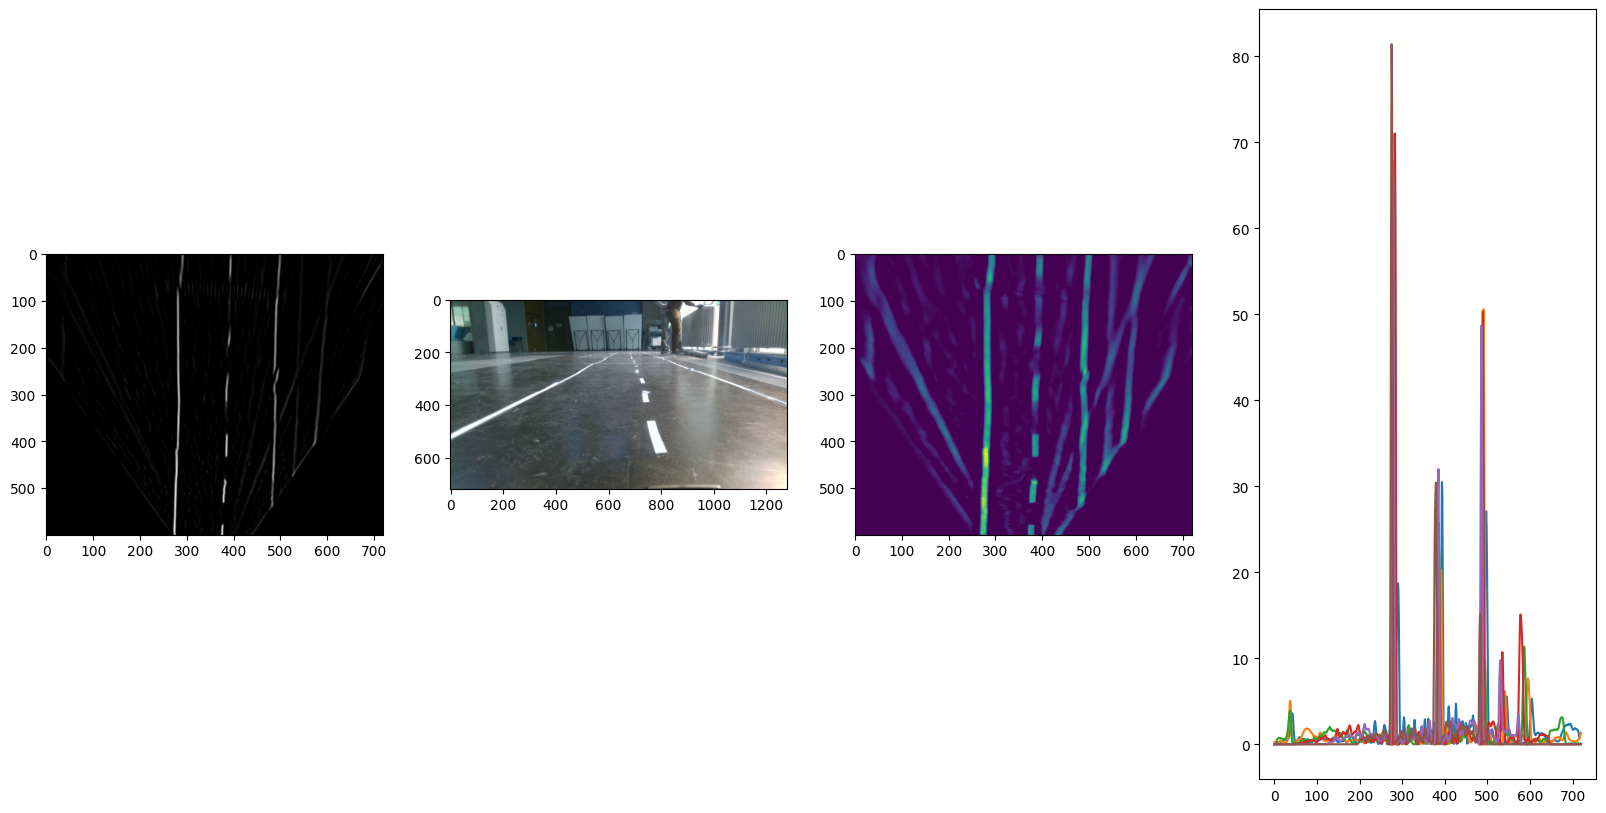

In [65]:
def extract_ground_plane_v2(rgbd_image):
    intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgbd_image.color, rgbd_image.depth, depth_scale=1.0, depth_trunc=5.0, convert_rgb_to_intensity=False
    )
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

    extrinsic_matrix = np.array(
            [
                [-1.0, 0.005, -0.004, -0.0],
                [0.005, 0.168, -0.986, -0.236],
                [-0.005, -0.986, -0.168, -0.062],
                [0.0, 0.0, 0.0, 1.0],
            ]
        )

    bev_transformer = BevTransformer.from_point_cloud(point_cloud, intrinsics.intrinsic_matrix, roi=BevRoi(0.5, 3, 3), scale=240)
    #bev_transformer = BevTransformer.from_roi(roi=BevRoi(0.3, 3, 3), intrinsic_matrix=intrinsics.intrinsic_matrix, extrinsic_matrix=extrinsic_matrix, scale=250)
    
    # img = bev_transformer.transform(np.asarray(rgbd_image.color))
    img = np.asarray(rgbd_image.color)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.warpPerspective(img, bev_transformer._H, bev_transformer._target_size, flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=img.mean())

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    
    filtered1 = cv.filter2D(img, -1, line_kernel(5, 3))
    filtered2 = cv.filter2D(img, -1, line_kernel(10, 3).T)
    filtered3 = cv.filter2D(img, -1, line_kernel(15, 3))
    filtered4 = cv.filter2D(img, -1, line_kernel(20, 3).T)

    print(filtered1.shape)

    filtered1 = (filtered1 - filtered1.min()) / (filtered1.max() - filtered1.min())
    print(filtered1.min(), filtered1.max()) 
    
    ax[0].imshow(filtered1, cmap="gray")
    ax[1].imshow(np.asarray(rgbd_image.color))
    ax[2].imshow(filtered3)

    for i in range(6):
        cols = np.sum(filtered1[100 * i: 100 * (i+1)], axis=0)
        ax[3].plot(cols)

    # cols = np.sum(filtered1, axis=0)
    # ax[3].plot(cols)
    

    
    #bev.t

extract_ground_plane_v2(rgbd_images[0])

src_points: [[-2085.83      550.4886 ]
 [  198.545     243.13753]
 [ 1112.295     231.06935]
 [ 3396.67      478.07953]]


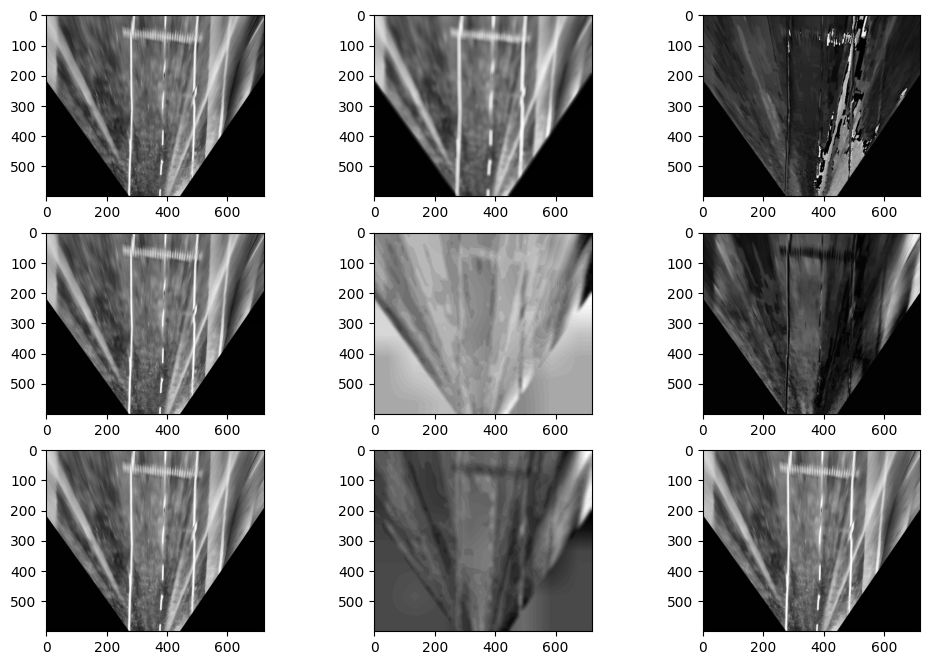

In [85]:
img = np.asarray(rgbd_images[0].color)

intrinsics = o3d.camera.PinholeCameraIntrinsic(1280, 720, fx=913.75, fy=911.92, cx=655.42, cy=350.49)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgbd_images[0].color, rgbd_images[0].depth, depth_scale=1.0, depth_trunc=5.0, convert_rgb_to_intensity=False
)
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

bev_transformer = BevTransformer.from_point_cloud(point_cloud, intrinsics.intrinsic_matrix, roi=BevRoi(0.5, 3, 3), scale=240)
bev = cv.warpPerspective(img, bev_transformer._H, bev_transformer._target_size, flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=0)

yuv = cv.cvtColor(bev, cv.COLOR_BGR2YUV)
hsv = cv.cvtColor(bev, cv.COLOR_BGR2HSV)

fig, ax = plt.subplots(3, 3, figsize=(12, 8))
for i in range(3):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #apply gauss
    yuv = cv.GaussianBlur(yuv, (11, 11), 10)
    yuv[:, :, i] = clahe.apply(yuv[:, :, i])
    hsv[:, :, i] = clahe.apply(hsv[:, :, i])
    bev[:, :, i] = clahe.apply(bev[:, :, i])
    ax[i, 0].imshow(bev[:, :, i], cmap="gray")
    ax[i, 1].imshow(yuv[:, :, i], cmap="gray")
    ax[i, 2].imshow(hsv[:, :, i], cmap="gray")
# ax[0].imshow(bev)
# ax[1].imshow(yuv[:, :, 0], cmap="gray")
# ax[2].imshow(hsv[:, :, 0], cmap="gray")